In [1]:
#import libraries
import numpy as np
import pandas as pd
import os
from datetime import time

In [2]:
# join the raw file folder
data_dir = os.path.join(os.getcwd(), "parquet_files")

In [100]:
# load the file
def load_data(filename):
  return pd.read_parquet(filename)

# create volume moving average
def create_volume_moving_average(df, candles = 8):
  df = df.copy()
  df[f"vma_{candles}"] = df["volume"].rolling(window=candles).mean()  
  return df

# resample logic
def resample_ohlcv(df, timeframe):
  return (df.resample(timeframe, label="right", closed="right").agg({
            "open": "first",
            "high": "max",
            "low": "min",
            "close": "last",
            "volume": "sum",
            "open_interest": "last"
        })
        .dropna(subset=["open"]))

# candle colour logic
def candlestick_colours(df):
  df = df.copy()
  df["candle"] = np.where(
    df["open"]>df["close"],"red", 
    np.where(df["open"]==df["close"],"white","green")
  )
  return df

# reversal logic
def reversal(df):
  df = df.copy()
  df["reversal"] = "None"
  bullish =( df["candle"].shift(1) == "red") & (df["candle"]=="green")
  bearish = (df["candle"].shift(1) == "green") & (df["candle"]=="red")
  df.loc[bullish, "reversal"] = "bullish"
  df.loc[bearish, "reversal"] = "bearish"
  return df

# englufing logic
def engulfing(df):
  df = df.copy()
  df["engulfing"] = "sluggish"
  bullish = (
      (df["reversal"] == "bullish") &
      (df["close"] > df["open"].shift(1)) & 
      (abs(df["close"] - df["open"])>=0.6 *abs(df["close"].shift(1) - df["open"].shift(1)))
  )
  bearish = (
      (df["reversal"] == "bearish") &
      (df["close"] < df["open"].shift(1)) & 
      (abs(df["close"] - df["open"])>=0.6 *abs(df["close"].shift(1) - df["open"].shift(1)))
  )
  df.loc[bullish, "engulfing"] = "bullish"
  df.loc[bearish, "engulfing"] = "bearish"
  return df

# volume check logic
def volume_check(df, candles=8):
  df = df.copy()
  df["volume_check"] = "lower"
  df.loc[df["volume"] > df[f"vma_{candles}"], "volume_check"] = "higher"
  return df

# signal logic
def signal(df ):
  df = df.copy()
  time_check = (df.index.time >= time(9,30) ) & (df.index.time <= time(14,40) )
  df["signal"] = 0
  long = time_check & (df["engulfing"].shift(1) == "bullish") & (df["volume_check"].shift(2) == "higher")
  short = time_check & (df["engulfing"].shift(1) == "bearish") & (df["volume_check"].shift(2) == "higher")
  df.loc[long, "signal"] = 1
  df.loc[short, "signal"] = -1
  return df

#entry logic
def entry(df):
  df = df.copy()
  df["entry_price"] = np.nan
  long = df["signal"] == 1
  short = df["signal"] == -1 
  df.loc[long | short, "entry_price"] = df["open"]
  return df

# sl logic
def stop_loss(df):
  df = df.copy()
  df["stop_loss"] = 0.0
  long = df["signal"] == 1
  short = df["signal"] == -1 
  df.loc[long, "stop_loss"] = df["low"].shift(1).rolling(2).min()
  df.loc[short, "stop_loss"] = df["high"].shift(1).rolling(2).max()
  return df

# risk in points logic 
def risk_in_points(df):
  df = df.copy()
  df["risk_in_points"]= np.nan 
  signal_present = (df["signal"] == 1) | (df["signal"] == -1)
  df.loc[signal_present, "risk_in_points"] = (df["open"] - df["stop_loss"])*(df["signal"])
  return df 
#exit logic
def take_profit(df,rr= 2):
  df = df.copy()
  df["take_profit"] = np.nan
  long = df["signal"] == 1
  short = df["signal"] == -1 
  df.loc[long, "take_profit"] = df["risk_in_points"]*rr + df["open"]
  df.loc[short, "take_profit"] = df["open"] - df["risk_in_points"]*rr
  return df

# quantity logic
def calc_quantity(df, monetary_risk = 1000):
  df = df.copy()
  df["quantity"] = 0.0
  signal_present = (df["signal"] == 1) | (df["signal"] == -1)
  df.loc[signal_present, "quantity"] = np.floor(monetary_risk / df.loc[signal_present, "risk_in_points"])
  return df

# trading simulation
def simulate_trade(df):
    df = df.copy()
    df["exit_reason"] = None
    df["exit_index"] = pd.NaT
    df["exit_price"] = np.nan

    trade_active_until = pd.NaT

    for i in range(len(df)):

      # block overlapping trades
      if pd.notna(trade_active_until) and df.index[i] <= trade_active_until:
          continue

      if df.iloc[i]["signal"] == 0:
          continue
      df.loc[df.index[i],'entry_time'] = df.index[i]
      sl = df.iloc[i]["stop_loss"]
      tp = df.iloc[i]["take_profit"]
      direction = df.iloc[i]["signal"]

      for j in range(i + 1, len(df)):
          high = df.iloc[j]["high"]
          low = df.iloc[j]["low"]
          open_price = df.iloc[j]["open"]
          signal = df.iloc[j]["signal"]

          if df.index[j].time() == time(15, 5):
              exit_reason, exit_price = "time_cutoff", open_price
              break

          if direction == 1:
              # if signal == -1:
              #     exit_reason, exit_price = "reversal", max(open_price, sl)
              #     break
              if low <= sl:
                  exit_reason, exit_price = "sl", sl
                  break
              if high >= tp:
                  exit_reason, exit_price = "tp", tp
                  break
          else:
              # if signal == 1:
              #     exit_reason, exit_price = "reversal", min(open_price, sl)
              #     break
              if high >= sl:
                  exit_reason, exit_price = "sl", sl
                  break
              if low <= tp:
                  exit_reason, exit_price = "tp", tp
                  break

      # record exit
      df.loc[df.index[i], ["exit_reason","exit_time","exit_price"]] = [exit_reason, df.index[j], exit_price]
      # lock until exit
      trade_active_until = df.index[j]

    return df

# transaction costs logic
def transaction_costs(df):
    df = df.copy()
    completed_trade = df['exit_time'].notna()
    # Turnover (buy + sell)
    df.loc[completed_trade, 'turnover'] = (
        (df.loc[completed_trade, 'entry_price'] + df.loc[completed_trade, 'exit_price'])
        * df.loc[completed_trade, 'quantity']
    )
    # Brokerage: 0.03% per side, capped at ₹20 per side
    brokerage_raw = 0.03/100 * df.loc[completed_trade, 'turnover'] / 2
    df.loc[completed_trade, 'brokerage'] = np.minimum(brokerage_raw, 20) * 2
    # STT: sell side only (intraday equity)
    df.loc[completed_trade, 'stt'] = (
        25/100000 * df.loc[completed_trade, 'exit_price'] * df.loc[completed_trade, 'quantity']
    )
    # Transaction charges
    df.loc[completed_trade, 'trans_charges'] = (
        0.00297/100 * df.loc[completed_trade, 'turnover']
    )
    # SEBI charges
    df.loc[completed_trade, 'sebi'] = (
        10/10000000 * df.loc[completed_trade, 'turnover']
    )
    # GST: only on brokerage + transaction charges
    df.loc[completed_trade, 'gst'] = (
        0.18 * (df.loc[completed_trade, 'brokerage'] + df.loc[completed_trade, 'trans_charges'])
    )
    # Stamp duty: buy side only
    df.loc[completed_trade, 'stamp_charges'] = (
        0.003/100 * df.loc[completed_trade, 'entry_price'] * df.loc[completed_trade, 'quantity']
    )

    # Total costs
    df.loc[completed_trade, 'total_costs'] = (
        df.loc[completed_trade, 'brokerage']
        + df.loc[completed_trade, 'stt']
        + df.loc[completed_trade, 'trans_charges']
        + df.loc[completed_trade, 'sebi']
        + df.loc[completed_trade, 'gst']
        + df.loc[completed_trade, 'stamp_charges']
    )

    return df

  
# post processing logic
def post_processing(df): 
  df = df.copy() 
  completed_trade = df['exit_time'].notna()
  df.loc[completed_trade,"pnl_points"] = (df.loc[completed_trade,"exit_price"] - df.loc[completed_trade,"entry_price"])* df.loc[completed_trade,"signal"] 
  df.loc[completed_trade,"monetary_pnl"] = df.loc[completed_trade,"pnl_points"] * df.loc[completed_trade,"quantity"] 
  df['net_pnl'] = df['monetary_pnl'] - df['total_costs']
  df["equity"] = df["net_pnl"].fillna(0).cumsum() 
  df["holding_time"] = df["exit_time"] - df["entry_time"]
  df["trade_direction"] = np.where(df["signal"]==1,"buy",np.where(df["signal"]==-1,"sell",""))
  df['drawdown'] = df['equity'].cummax() - df['equity']
  return df


# final results logic
def result(pnl):
  pnl = pnl.dropna()
  pnl = pnl[pnl!=0]
  wins = pnl[pnl>0]
  losses = pnl[pnl<0]
  avg_win = wins.mean()
  avg_loss = losses.mean()
  win_rate = len(wins)/len(pnl)
  loss_rate = len(losses)/len(pnl)
  expectancy = avg_win*win_rate+avg_loss*loss_rate
  drawdown = max(pnl.fillna(0).cumsum().cummax() - pnl.fillna(0).cumsum()) 
  return {
    "avg_win": avg_win,
    "avg_loss": avg_loss,
    "win_rate": win_rate,
    "loss_rate": loss_rate,
    "expectancy": expectancy,
    "drawdown": drawdown
  } 
  
# trades dataframe logic
def trades_df(df):
  df =df.copy()
  trades_df = df[['trade_direction','quantity','entry_time','exit_time','stop_loss','take_profit','risk_in_points','monetary_pnl','total_costs', 'net_pnl', 'holding_time','equity','drawdown']]
  trades_df = trades_df[trades_df['exit_time'].notna()]
  return trades_df

In [117]:
first_test = os.path.join(data_dir, "RELIANCE.parquet")
reliance = load_data(first_test)
reliance = resample_ohlcv(reliance, "5min")
reliance = create_volume_moving_average(reliance, 8)
reliance = candlestick_colours(reliance)
reliance = reversal(reliance) 
reliance = engulfing(reliance)
reliance = volume_check(reliance, candles = 8)
reliance = signal(reliance)
reliance = entry(reliance)
reliance = stop_loss(reliance)
reliance = risk_in_points(reliance)
reliance = take_profit(reliance, rr = 2)
reliance = calc_quantity(reliance, monetary_risk=1000)
reliance = simulate_trade(reliance)
reliance = transaction_costs(reliance)
reliance = post_processing(reliance)

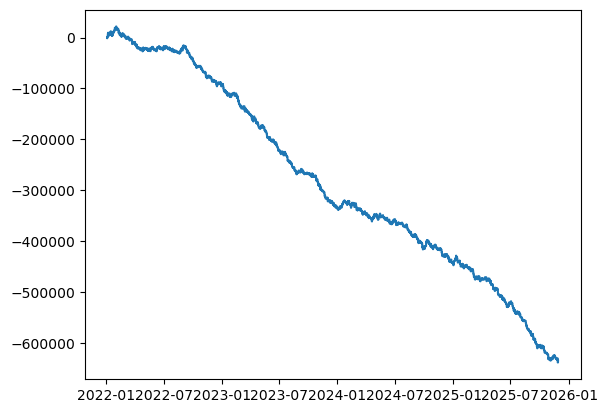

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(reliance['equity'])
plt.show()

In [116]:
print(result(reliance['net_pnl']))

{'avg_win': 1833.449250892042, 'avg_loss': -1168.9016323209873, 'win_rate': 0.3738191632928475, 'loss_rate': 0.6261808367071525, 'expectancy': -46.56533724675103, 'drawdown': 48217.07809456494}
